<a href="https://colab.research.google.com/github/jchen0000/widsdatathon2025/blob/main/python/Jiaqi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns

# Data Processing

In [59]:
# prompt: Access data from google drive
from google.colab import drive
drive.mount('/content/drive')

# Import train categorical data (1213, 10)
train_cat = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
# train_cat.shape
# train_cat.describe()

# Import train quantitative data (1213, 19)
train_quant = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
# train_quant.shape
# train_quant.describe()

# Import solution w outcome data (1213, 3)
train_sol = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")
# train_sol.shape
# train_sol.describe()

# Merge train datasets on the participant ID
combined_train_data = pd.merge(train_cat, train_quant, on='participant_id')    # (1213, 28)
train_with_outcome = pd.merge(combined_train_data, train_sol, on='participant_id')  # (1213, 30)

# Import test categorical data (304, 10)
test_cat = pd.read_excel("drive/My Drive/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx")

# Import test quantitative data (304, 19)
test_quant = pd.read_excel("drive/My Drive/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx")

# Merge test datasets on the participant ID  (304, 28)
combined_test_data = pd.merge(test_cat, test_quant, on='participant_id')
test_no_id = combined_test_data.drop(columns=['participant_id'])

# Import train MRI data (1213, 19901)
train_mri_filepath = "drive/My Drive/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv"
train_mri = pd.read_csv(train_mri_filepath)

# Import test MRI data
test_mri_filepath = "drive/My Drive/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_mri = pd.read_csv(test_mri_filepath)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Train fMRI Heatmap

The matrix and heatmap in MRI dataset represent functional connectivity between different regions of the brain for each subject.

The 200x200 matrix represents pairwise connectivity between different brain regions, where 200 is the number of regions.

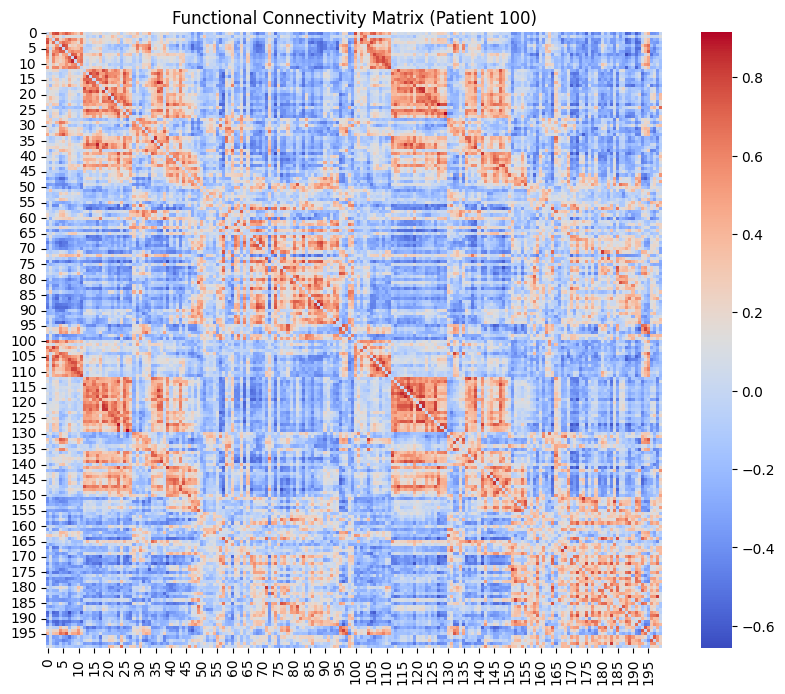

In [60]:
from scipy.spatial.distance import squareform

# Process MRI data

# Columns represent a functional connectivity matrix.
# N = 200 meaning each patient’s connectivity matrix is 200 × 200
N = int((1 + np.sqrt(1 + 8 * 19900)) / 2)

# Remove first line, convert csv file to a functional connectome matrix
train_matrix_data = train_mri.iloc[:, 1:].to_numpy(dtype=float)
# matrix_data.shape (1213, 19900)

# Convert first patient’s vector (19900 values) to full 200x200 matrix
subject_index = 100    # patient n (0, 1212)
subject_vector = train_matrix_data[subject_index]
subject_matrix = squareform(subject_vector)  # Reconstruct NxN matrix

# MRI Heatmap of one patient
plt.figure(figsize=(10, 8))
sns.heatmap(subject_matrix, cmap="coolwarm", square=True)
plt.title(f"Functional Connectivity Matrix (Patient {subject_index})")
plt.show()



# Combine Train Metadata and fMRI data

Result: X_train


Clean combined data: replace NA with mean value, separate patient ID.

In [51]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Combine metadata and fMRI into one feature matrix
features = np.hstack([combined_train_data, train_matrix_data])
#features.shape(1213, 19930)

# Check if any elements are strings by checking the type of the array
# if features.dtype == 'O':  # 'O' means object, often used for strings
#     print("There are string values in the matrix.")

# Ensure features data is all numeric
# Replace "NA" with np.nan
features[features == "NA"] = np.nan

# Separate patient ID
patient_ids = features[:, 0]  # Extract patient IDs
features_no_id = features[:, 1:]  # Extract the rest of the feature matrix

# Convert the features_no_id to float (ignoring patient IDs)
features_no_id = features_no_id.astype(float)

# Convert the matrix to float type
features_no_id = features_no_id.astype(float)
# print(features_no_id.dtype) float64

# Impute missing values in features_no_id
# imputer_metadata = SimpleImputer(strategy='mean')  # For numerical columns, use 'mean', 'median', or 'most_frequent'
# combined_metadata_imputed = imputer_metadata.fit_transform(features_no_id)  # (1213, 19927)

# Impute missing values with KNN imputation
imputer_metadata = KNNImputer(n_neighbors=5)  # Using KNN for imputation instead of mean
combined_metadata_imputed = imputer_metadata.fit_transform(features_no_id)  # (1213, 19927)

# Combine patient IDs back with the processed features_no_id (object)
features = np.hstack([patient_ids.reshape(-1, 1), features_no_id])   # (1213, 19928)

In [9]:
# Save Imputed Data
# df = pd.DataFrame(combined_metadata_imputed)
# df.to_csv('/content/drive/My Drive/widsdatathon2025/Work/Processed Data/new_imputed_train.csv', index=False)

# Import Lasso-Imputed Train Data

In [48]:
# !wget "https://github.com/jchen0000/widsdatathon2025/blob/main/data/train/TRAIN_CATEGORICAL_METADATA_imputed_Jing.xlsx?raw=true" -O train_cat2.xlsx
# train_cat2 = pd.read_excel("train_cat.xlsx")      # (1213, 10)

# !wget "https://github.com/jchen0000/widsdatathon2025/blob/main/data/train/TRAIN_QUANTITATIVE_METADATA_imputed_Jing.xlsx?raw=true" -O train_quant2.xlsx
# train_quant2 = pd.read_excel("train_quant2.xlsx")  # (1213, 19)

# # Merge train datasets on the participant ID
# combined_train_data2 = pd.merge(train_cat2, train_quant2, on='participant_id')
# train_with_outcome2 = pd.merge(combined_train_data2, train_sol, on='participant_id')  # (1213, 30)

# # Combine metadata and fMRI into one feature matrix
# features2 = np.hstack([combined_train_data2, train_matrix_data])


# # Remove patient ID
# combined_metadata_imputed = combined_metadata_imputed[:, 1:]   # (1213, 19927)
# combined_metadata_imputed = combined_metadata_imputed.astype(float)

--2025-03-30 19:58:33--  https://github.com/jchen0000/widsdatathon2025/blob/main/data/train/TRAIN_CATEGORICAL_METADATA_imputed_Jing.xlsx?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jchen0000/widsdatathon2025/raw/refs/heads/main/data/train/TRAIN_CATEGORICAL_METADATA_imputed_Jing.xlsx [following]
--2025-03-30 19:58:33--  https://github.com/jchen0000/widsdatathon2025/raw/refs/heads/main/data/train/TRAIN_CATEGORICAL_METADATA_imputed_Jing.xlsx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jchen0000/widsdatathon2025/refs/heads/main/data/train/TRAIN_CATEGORICAL_METADATA_imputed_Jing.xlsx [following]
--2025-03-30 19:58:33--  https://raw.githubusercontent.com/jchen0000/widsdatathon2025/refs/heads/main/data/train/TRAIN_CATEGORICAL_METADATA_i

# Test fMRI Heatmap

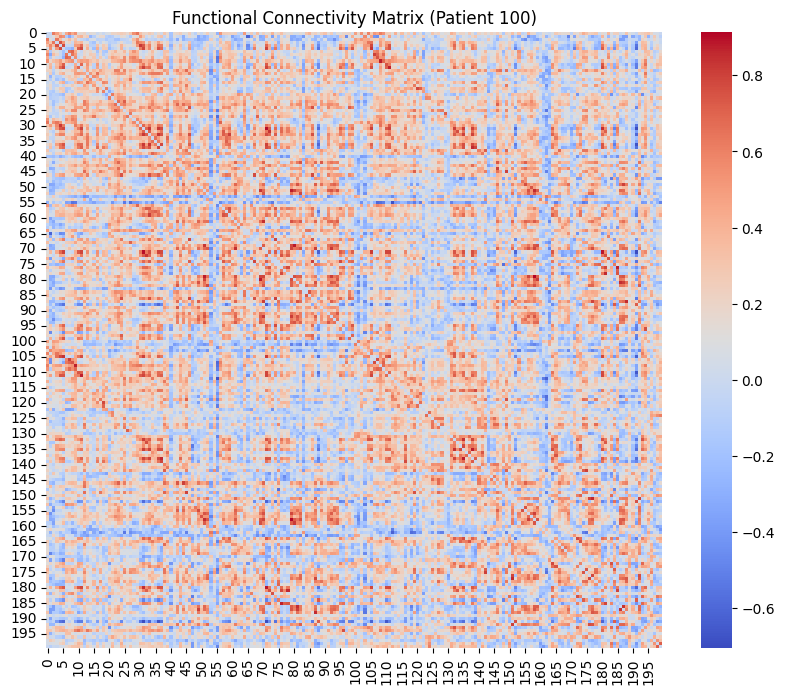

In [6]:
# Remove first line, convert csv file to a functional connectome matrix
test_matrix_data = test_mri.iloc[:, 1:].to_numpy(dtype=float)
# test_matrix_data.shape

# Convert first patient’s vector (19900 values) to full 200x200 matrix
test_subject_index = 100    # patient n (0, 1212)
test_subject_vector = test_matrix_data[test_subject_index]
test_subject_matrix = squareform(test_subject_vector)  # Reconstruct NxN matrix

# MRI Heatmap of one patient
plt.figure(figsize=(10, 8))
sns.heatmap(test_subject_matrix, cmap="coolwarm", square=True)
plt.title(f"Functional Connectivity Matrix (Patient {subject_index})")
plt.show()

# Combine Test Metadata and fMRI data

Result: X_test


In [7]:
# Combine metadata and fMRI into one feature matrix
test_features = np.hstack([combined_test_data, test_matrix_data])

# Check if any elements are strings by checking the type of the array
# if features.dtype == 'O':  # 'O' means object, often used for strings
#     print("There are string values in the matrix.")

# Ensure features data is all numeric
# Replace "NA" with np.nan
test_features[test_features == "NA"] = np.nan

# Separate patient ID
test_patient_ids = test_features[:, 0]  # Extract patient IDs
test_features_no_id = test_features[:, 1:]  # Extract the rest of the feature matrix

# Convert the features_no_id to float (ignoring patient IDs)
test_features_no_id = test_features_no_id.astype(float)

# Convert the matrix to float type
test_features_no_id = test_features_no_id.astype(float)
# print(features_no_id.dtype) float64

# Impute missing values in features_no_id
# imputer_test_metadata = SimpleImputer(strategy='mean')  # For numerical columns, use 'mean', 'median', or 'most_frequent'
# combined_test_metadata_imputed = imputer_test_metadata.fit_transform(test_features_no_id)

# Impute missing values with KNN imputation
imputer_test_metadata = KNNImputer(n_neighbors=5)  # Using KNN for imputation instead of mean
combined_test_metadata_imputed = imputer_test_metadata.fit_transform(test_features_no_id)  # (304, 19927)


# Combine patient IDs back with the processed features_no_id (object)
test_features = np.hstack([test_patient_ids.reshape(-1, 1), test_features_no_id])

# Data Input

In [61]:
combined_metadata_imputed = pd.read_csv('/content/drive/My Drive/widsdatathon2025/Work/Processed Data/new_imputed_train.csv')
combined_test_metadata_imputed = pd.read_csv('/content/drive/My Drive/widsdatathon2025/Work/Processed Data/imputed_test_jiaqi.csv')

# LDA

1.   Fit LDA on training data.
2.   Transform both train and test data into topic distributions.
3.   Use those topic distributions as input features to a classifier (like logistic regression or random forest) to predict ADHD diagnosis or sex.
4.   Evaluate the accuracy of that classifier.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import LatentDirichletAllocation
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier

# # Step 1: Train-test split (features only, no labels in LDA training)
# X_train, X_test, y_train, y_test = train_test_split(
#     combined_metadata_imputed,  # metadata + fMRI combined
#     train_sol,     # ADHD diagnosis (or sex)
#     test_size=0.2,
#     random_state=42
# )

# LDA expects non-negative data, shift if needed
combined_metadata_imputed += np.abs(combined_metadata_imputed.min(axis=0))
combined_test_metadata_imputed += np.abs(combined_test_metadata_imputed.min(axis=0))

# (1213, 19927)
X_train = combined_metadata_imputed
# (304, 19927)
X_test = combined_test_metadata_imputed
# (1213, 3)
y_train = train_sol.drop(columns=['participant_id'])

# Fit LDA on training data (features only)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_train)

# Get topic distributions for train and test
train_topic_distributions = lda.transform(X_train)
test_topic_distributions = lda.transform(X_test)

# Train classifier on topic distributions to predict ADHD (supervised step)
clf = RandomForestClassifier(random_state=42)
clf.fit(train_topic_distributions, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Cross-Validation
from sklearn.model_selection import cross_val_score

# Evaluate using cross-validation (e.g., 5-fold cross-validation)
cv_scores = cross_val_score(clf, train_topic_distributions, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())



Cross-validation scores: [0.54320988 0.51028807 0.41563786 0.31404959 0.05371901]
Mean CV score: 0.36738087950209164


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into train and test sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    combined_metadata_imputed, train_sol.drop(columns=['participant_id']), test_size=0.2, random_state=42)

# Train the LDA and Random Forest model again using the split data
lda.fit(X_train_split)
train_topic_distributions = lda.transform(X_train_split)
test_topic_distributions = lda.transform(X_test_split)

clf.fit(train_topic_distributions, y_train_split)

# Now you can evaluate with the new y_test_split
y_pred = clf.predict(test_topic_distributions)
print("Accuracy:", accuracy_score(y_test_split, y_pred))

# Whole sample with Mean Imputation Accuracy: 0.5185185185185185
# Whole sample with KNN Imputation Accuracy: 0.5432098765432098
# 1103 components with KNN Imputation Accuracy: 0.4567901234567901

Accuracy: 0.5432098765432098


# Dimension Reduction
PCA

Optimal number of components to retain 95% variance: 1103


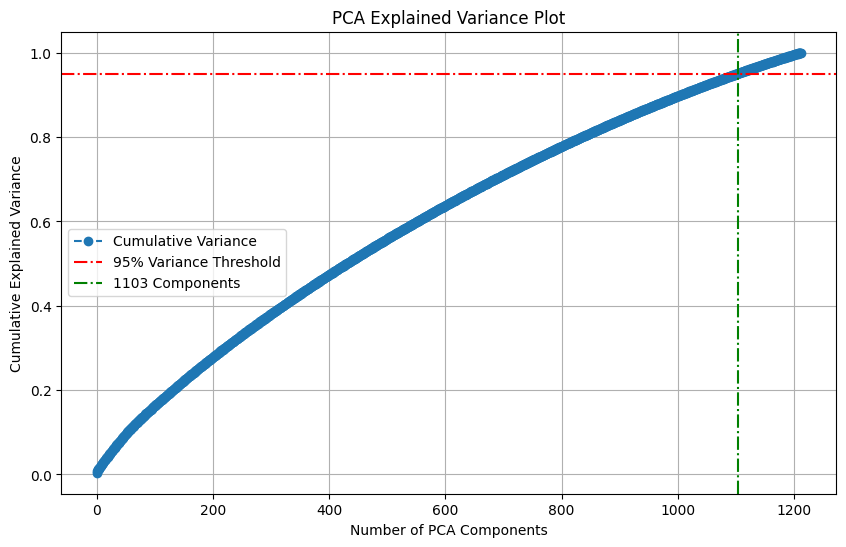

Reduced MRI feature shape: (1213, 1103)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data before PCA
scaler = StandardScaler()
train_mri_scaled = scaler.fit_transform(train_matrix_data)

# Fit PCA without limiting components
pca = PCA()
pca.fit(train_mri_scaled)

# Cumulative variance explained
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 95% variance
optimal_components = np.argmax(explained_variance >= 0.95) + 1

print(f"Optimal number of components to retain 95% variance: {optimal_components}")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o', linestyle='--', label="Cumulative Variance")
plt.axhline(y=0.95, color='r', linestyle='-.', label="95% Variance Threshold")
plt.axvline(x=optimal_components, color='g', linestyle='-.', label=f"{optimal_components} Components")
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance Plot')
plt.legend()
plt.grid()
plt.show()

# Now, apply PCA with the optimal number of components
pca_final = PCA(n_components=optimal_components)
train_mri_reduced = pca_final.fit_transform(train_mri_scaled)

print(f"Reduced MRI feature shape: {train_mri_reduced.shape}")


Train LDA model with 1103 components.
Train LDA Separately for Each Outcome.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Extract ADHD_Outcome as one target
train_labels_adhd = train_sol["ADHD_Outcome"].values  # (1213,)

# Extract Sex_F as another target
train_labels_sex = train_sol["Sex_F"].values  # (1213,)


# Split for ADHD outcome
X_train, X_val, y_train, y_val = train_test_split(train_mri_reduced, train_labels_adhd, test_size=0.2, stratify=train_labels_adhd, random_state=42)

# Train LDA Model for ADHD
lda_adhd = LinearDiscriminantAnalysis()
lda_adhd.fit(X_train, y_train)

# Predict & Evaluate
y_val_pred = lda_adhd.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"LDA Accuracy for ADHD Outcome: {accuracy:.4f}")

# LDA Accuracy for ADHD Outcome: 0.4897

# Split for Sex_F outcome
X_train, X_val, y_train, y_val = train_test_split(train_mri_reduced, train_labels_sex, test_size=0.2, stratify=train_labels_sex, random_state=42)

# Train LDA Model for Sex_F
lda_sex = LinearDiscriminantAnalysis()
lda_sex.fit(X_train, y_train)

# Predict & Evaluate
y_val_pred = lda_sex.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"LDA Accuracy for Sex_F Outcome: {accuracy:.4f}")

# LDA Accuracy for Sex_F Outcome: 0.5144

LDA Accuracy for ADHD Outcome: 0.4897
LDA Accuracy for Sex_F Outcome: 0.5144


# Neural Network

**Validation Loss** refers to the loss (or error) of the model when evaluated on the validation dataset. The loss function is a measure of how well the model’s predictions match the true values.

*   Lower validation loss means better performance on the validation set.
*   Higher validation loss means the model is struggling to generalize to new, unseen data.

**AUC** stands for Area Under the Receiver Operating Characteristic Curve (ROC Curve). It is a measure of a model's ability to distinguish between classes (for binary classification problems like yours).

*   AUC = 1.0: Perfect model, always correctly classifies all positive and negative cases.
*   AUC = 0.5: Random guesses, no better than flipping a coin.
*   AUC < 0.5: Worse than random guessing, meaning the model is consistently making incorrect predictions.


## Calculate Weighted F1 Score of Combined Model for ADHD Outcome and Sex

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import numpy as np

# --- Define the function to compute weighted F1 score ---
def compute_weighted_f1(y_true_adhd, y_pred_adhd, y_true_sex, y_pred_sex):
    """
    Compute the final weighted F1 score for the competition.
    Female ADHD cases (where ADHD_Outcome==1 and Sex_F==1) are given 2x weight.
    The final score is the average of the weighted F1 for ADHD_Outcome and the F1 for Sex_F.
    """
    # Create sample weights for ADHD_Outcome: weight=2 for female ADHD cases, else 1.
    weights = np.ones_like(y_true_adhd, dtype=float)
    weights[(y_true_adhd == 1) & (y_true_sex == 1)] = 2.0

    # Calculate weighted F1 for ADHD_Outcome
    f1_adhd = f1_score(y_true_adhd, y_pred_adhd, sample_weight=weights)
    # Calculate standard F1 for Sex_F
    f1_sex = f1_score(y_true_sex, y_pred_sex)

    # Final leaderboard score: average of the two F1 scores
    final_f1 = (f1_adhd + f1_sex) / 2.0
    return final_f1, f1_adhd, f1_sex

# --- Prepare the data ---
# Use combined_metadata_imputed as input features.
X = combined_metadata_imputed  # (1213, 19927)
# Extract targets from train_sol:
y_adhd = train_sol['ADHD_Outcome'].values  # Binary labels (0 or 1)
y_sex  = train_sol['Sex_F'].values         # Binary labels (0 or 1)

# Standardize features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets.
# Note: We split the labels separately but the splits will be aligned because we use the same X_scaled.
X_train_split, X_val_split, y_train_adhd_split, y_val_adhd_split = train_test_split(
    X_scaled, y_adhd, test_size=0.2, random_state=42
)
_, _, y_train_sex_split, y_val_sex_split = train_test_split(
    X_scaled, y_sex, test_size=0.2, random_state=42
)

# --- Build the multi-output neural network model ---
input_layer = Input(shape=(X_train_split.shape[1],))
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)

# Two separate output layers:
output_adhd = Dense(1, activation='sigmoid', name='adhd_output')(x)
output_sex  = Dense(1, activation='sigmoid', name='sex_output')(x)

model = Model(inputs=input_layer, outputs=[output_adhd, output_sex])

# Compile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics={'adhd_output': 'accuracy', 'sex_output': 'accuracy'})


# Set up early stopping.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Train the model ---
history = model.fit(
    X_train_split,
    {'adhd_output': y_train_adhd_split, 'sex_output': y_train_sex_split},
    epochs=100,
    batch_size=32,
    validation_data=(X_val_split, {'adhd_output': y_val_adhd_split, 'sex_output': y_val_sex_split}),
    callbacks=[early_stopping]
)

# --- Evaluate the model ---
results = model.evaluate(X_val_split, {'adhd_output': y_val_adhd_split, 'sex_output': y_val_sex_split})
print("Evaluation Results:", results)

# --- Make predictions on the validation set ---
predictions = model.predict(X_val_split)
# predictions is a list: predictions[0] for ADHD_Outcome, predictions[1] for Sex_F.
y_val_pred_adhd = (predictions[0] > 0.5).astype(int).flatten()
y_val_pred_sex  = (predictions[1] > 0.5).astype(int).flatten()

# --- Compute the weighted F1 score ---
final_f1, f1_adhd, f1_sex = compute_weighted_f1(y_val_adhd_split, y_val_pred_adhd, y_val_sex_split, y_val_pred_sex)

print(f"ADHD F1 Score (weighted): {f1_adhd:.4f}")
print(f"Sex_F F1 Score: {f1_sex:.4f}")
print(f"Final Weighted F1 Score: {final_f1:.4f}")

# ADHD F1 Score (weighted): 0.8566
# Sex_F F1 Score: 0.2979
# Final Weighted F1 Score: 0.5772

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - adhd_output_accuracy: 0.5310 - adhd_output_loss: 0.7490 - loss: 5.3257 - sex_output_accuracy: 0.5523 - sex_output_loss: 0.7352 - val_adhd_output_accuracy: 0.5638 - val_adhd_output_loss: 0.7022 - val_loss: 5.2112 - val_sex_output_accuracy: 0.6955 - val_sex_output_loss: 0.7030
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - adhd_output_accuracy: 0.6230 - adhd_output_loss: 0.7133 - loss: 5.1491 - sex_output_accuracy: 0.5720 - sex_output_loss: 0.6843 - val_adhd_output_accuracy: 0.6626 - val_adhd_output_loss: 0.6278 - val_loss: 4.8189 - val_sex_output_accuracy: 0.6914 - val_sex_output_loss: 0.6202
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - adhd_output_accuracy: 0.6320 - adhd_output_loss: 0.6523 - loss: 4.8041 - sex_output_accuracy: 0.6183 - sex_output_loss: 0.6516 - val_adhd_output_accuracy: 0.6872 - val_adhd_output_loss: 0.6246 - val_loss: 4.5472 - val_sex_output_accuracy: 0.6996 - val_sex_output_loss: 0.6344
Epoch 4/10

# Threshold Tuning

In [65]:
# For ADHD:
#    y_val_adhd_prob: predicted probabilities from the model for ADHD_Outcome (shape: (n_samples,))
#    y_val_adhd: true ADHD_Outcome labels (0 or 1)
# For Sex_F:
#    y_val_sex_prob: predicted probabilities from the model for Sex_F (shape: (n_samples,))
#    y_val_sex: true Sex_F labels (0 or 1)

y_val_adhd_prob = predictions[0].flatten()
y_val_sex_prob  = predictions[1].flatten()

# --- Define the function to compute weighted F1 score ---
def compute_weighted_f1(y_true_adhd, y_pred_adhd, y_true_sex, y_pred_sex):
    """
    Compute the final weighted F1 score.
    Female ADHD cases (where ADHD_Outcome==1 and Sex_F==1) are given 2x weight.
    Returns:
       final_f1: the average of the weighted ADHD F1 and the Sex_F F1.
       f1_adhd: F1 score for ADHD_Outcome using sample weights.
       f1_sex:  F1 score for Sex_F (unweighted).
    """
    weights = np.ones_like(y_true_adhd, dtype=float)
    weights[(y_true_adhd == 1) & (y_true_sex == 1)] = 2.0
    f1_adhd = f1_score(y_true_adhd, y_pred_adhd, sample_weight=weights)
    f1_sex = f1_score(y_true_sex, y_pred_sex)
    final_f1 = (f1_adhd + f1_sex) / 2.0
    return final_f1, f1_adhd, f1_sex

# --- Define a range of thresholds to test ---
thresholds = np.linspace(0, 1, 101)  # from 0.00 to 1.00 in steps of 0.01

best_final_f1 = 0.0
best_thr_adhd = 0.0
best_thr_sex  = 0.0
best_f1_adhd = 0.0
best_f1_sex  = 0.0

# --- Perform a 2D threshold sweep ---
for thr_a in thresholds:
    for thr_s in thresholds:
        y_pred_adhd = (y_val_adhd_prob > thr_a).astype(int)
        y_pred_sex  = (y_val_sex_prob > thr_s).astype(int)
        final_f1, f1_adhd, f1_sex = compute_weighted_f1(y_val_adhd_split, y_pred_adhd, y_val_sex_split, y_pred_sex)
        if final_f1 > best_final_f1:
            best_final_f1 = final_f1
            best_thr_adhd = thr_a
            best_thr_sex  = thr_s
            best_f1_adhd = f1_adhd
            best_f1_sex  = f1_sex

print(f"Best ADHD Threshold: {best_thr_adhd:.2f} with F1: {best_f1_adhd:.4f}")
print(f"Best Sex_F Threshold: {best_thr_sex:.2f} with F1: {best_f1_sex:.4f}")
print(f"Best Final Weighted F1: {best_final_f1:.4f}")

# Best ADHD Threshold: 0.37 with F1: 0.8762
# Best Sex_F Threshold: 0.02 with F1: 0.4586
# Best Final Weighted F1: 0.6674


Best ADHD Threshold: 0.00 with F1: 0.8728
Best Sex_F Threshold: 0.20 with F1: 0.4599
Best Final Weighted F1: 0.6664


# Final Submission

In [64]:

# ----------------------------
# 1. Prepare Test Features
# ----------------------------
# test_features was constructed as follows:
# - combined_test_data and test_matrix_data were merged to form a matrix.
# - "NA" values were replaced with np.nan.
# - The first column (patient IDs) was separated.
# - Missing values were imputed (e.g., using KNN imputation).
#
# In your code, you ended with:
# combined_test_metadata_imputed = imputer_test_metadata.fit_transform(test_features_no_id)
# and then:
# test_features = np.hstack([test_patient_ids.reshape(-1, 1), test_features_no_id])
#
# For prediction, we want to use the imputed features that match the training data.
# Apply the same StandardScaler (fitted on the training data) to the test features.
final_test_features = scaler.transform(combined_test_metadata_imputed)  # Shape: (n_test_samples, n_features)

# ----------------------------
# 2. Make Predictions on Test Data
# ----------------------------
# Using the multi-output model, predictions will be a list of arrays:
#   test_predictions[0] corresponds to ADHD_Outcome probabilities.
#   test_predictions[1] corresponds to Sex_F probabilities.
test_predictions = model.predict(final_test_features)

# Flatten the predictions (if needed) so they are 1D arrays:
adhd_probs = test_predictions[0].flatten()
sex_probs  = test_predictions[1].flatten()

# ----------------------------
# 3. Apply Optimal Thresholds
# ----------------------------
# Use the optimal thresholds found from threshold tuning.
# (For example, these variables should have been computed during your threshold tuning process.)
test_pred_adhd = (adhd_probs > best_thr_adhd).astype(int)
test_pred_sex  = (sex_probs > best_thr_sex).astype(int)

# ----------------------------
# 4. Create the Submission DataFrame
# ----------------------------
# Ensure that test_patient_ids is a 1D array containing the IDs.
submission_df = pd.DataFrame({
    'participant_id': test_patient_ids.flatten(),  # Use your test IDs
    'ADHD_Outcome': test_pred_adhd,
    'Sex_F': test_pred_sex
})

# ----------------------------
# 5. Save to CSV
# ----------------------------
submission_df.to_csv('/content/drive/My Drive/widsdatathon2025/Work/Submission/submission.csv', index=False)
print("Submission file saved as submission.csv")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Submission file saved as submission.csv
